In [1]:
%pip install dmba

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 50.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

import matplotlib.pyplot as plt

import dmba
from dmba import classificationSummary
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models

from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV


%matplotlib inline

# Get the location of the data to be used:
my_drive_path = "/content/drive/MyDrive/SUNY/Class Material/2024 Fall/MSA550A/Python Class Work/msa550-code-files/data/"


Colab environment detected.


In [4]:
example_df = dmba.load_data('TinyData.csv')
example_df.head(1)

,Obs.,Fat,Salt,Acceptance
0,1,0.2,0.9,like


In [5]:
predictors = ['Fat', 'Salt']
outcome = 'Acceptance'

X = example_df[predictors]
y = example_df[outcome]
classes = sorted(y.unique())

clf = MLPClassifier(hidden_layer_sizes=[3], activation='logistic', solver='lbfgs', random_state=1)
clf.fit(X, y)
clf.predict(X)

# Network structure
print('Intercepts')
print(clf.intercepts_)

print('Weights')
print(clf.coefs_)

# Prediction
print(pd.concat([
    example_df,
    pd.DataFrame(clf.predict_proba(X), columns=classes)
], axis=1))

Intercepts
[array([0.13368042, 4.07247549, 7.00768105]), array([14.3074867])]
Weights
[array([[ -1.3065648 ,  -4.20427797, -13.29587331],
       [ -0.04399729,  -4.91606921,  -6.03356987]]), array([[ -0.27348314],
       [ -9.01211576],
       [-17.63504684]])]
   Obs.  Fat  Salt Acceptance   dislike      like
0     1  0.2   0.9       like  0.000490  0.999510
1     2  0.1   0.1    dislike  0.999994  0.000006
2     3  0.2   0.4    dislike  0.999741  0.000259
3     4  0.2   0.5    dislike  0.997368  0.002632
4     5  0.4   0.5       like  0.002133  0.997867
5     6  0.3   0.8       like  0.000075  0.999925


In [6]:
# Pretty print layers
for i, (weights, intercepts) in enumerate(zip(clf.coefs_, clf.intercepts_)):
    print('Hidden layer' if i == 0 else 'Output layer', '{0[0]} => {0[1]}'.format(weights.shape))
    print(' Intercepts:\n ', intercepts)
    print(' Weights:')
    for weight in weights:
        print(' ', weight)
    print()


Hidden layer 2 => 3
 Intercepts:
  [0.13368042 4.07247549 7.00768105]
 Weights:
  [ -1.3065648   -4.20427797 -13.29587331]
  [-0.04399729 -4.91606921 -6.03356987]

Output layer 3 => 1
 Intercepts:
  [14.3074867]
 Weights:
  [-0.27348314]
  [-9.01211576]
  [-17.63504684]



In [7]:
classificationSummary(y, clf.predict(X), class_names=classes)

Confusion Matrix (Accuracy 1.0000)

        Prediction
 Actual dislike    like
dislike       3       0
   like       0       3


In [9]:
accidents_df = dmba.load_data('accidentsnn.csv')
input_vars = ['ALCHL_I', 'PROFIL_I_R', 'VEH_INVL']

accidents_df.SUR_COND = accidents_df.SUR_COND.astype('category')
accidents_df.MAX_SEV_IR = accidents_df.MAX_SEV_IR.astype('category')

# convert the categorical data into dummy variables
# exclude the column for SUR_COND 9 = unknown
processed = pd.get_dummies(accidents_df, columns=['SUR_COND']).drop(columns=['SUR_COND_9'])

outcome = 'MAX_SEV_IR'
predictors = [c for c in processed.columns if c != outcome]

# partition data
X = processed[predictors]
y = processed[outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

# train neural network with 2 hidden nodes
clf = MLPClassifier(hidden_layer_sizes=[2], activation='logistic', solver='lbfgs',
                    random_state=1)
clf.fit(train_X, train_y.values)

# training performance (use idxmax to revert the one-hot-encoding)
classificationSummary(train_y, clf.predict(train_X))

# validation performance
classificationSummary(valid_y, clf.predict(valid_X))

Confusion Matrix (Accuracy 0.8664)

       Prediction
Actual   0   1   2
     0 331   0   1
     1   0 180   0
     2  30  49   8
Confusion Matrix (Accuracy 0.8550)

       Prediction
Actual   0   1   2
     0 218   0   1
     1   0 119   0
     2  24  33   5


In [ ]:
outcome

'MAX_SEV_IR'

## Fitting class probabilities separately

In [10]:
accidents_df = dmba.load_data('accidentsnn.csv')
input_vars = ['ALCHL_I', 'PROFIL_I_R', 'VEH_INVL']

accidents_df.SUR_COND = accidents_df.SUR_COND.astype('category')
accidents_df.MAX_SEV_IR = accidents_df.MAX_SEV_IR.astype('category')

# convert the categorical data into dummy variables
processed = pd.get_dummies(accidents_df)
# drop the column for SUR_COND 9 = unknown
processed = processed.drop(columns=['SUR_COND_9'])

outcome = ['MAX_SEV_IR_0', 'MAX_SEV_IR_1', 'MAX_SEV_IR_2']
predictors = [c for c in processed.columns if c not in outcome]
classes = sorted(outcome)

# partition data
X = processed[predictors]
y = processed[outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

# train neural network with 2 hidden nodes
clf = MLPClassifier(hidden_layer_sizes=[2], activation='logistic', solver='lbfgs',
                    random_state=1, max_iter=500)
clf.fit(train_X, train_y)

# training performance (use idxmax to revert the one-hot-encoding)
trainPrediction = pd.DataFrame(clf.predict(train_X), columns=outcome).idxmax(axis=1)
classificationSummary(train_y.idxmax(axis=1), trainPrediction, class_names=classes)

# validation performance
validPrediction = pd.DataFrame(clf.predict(valid_X), columns=outcome).idxmax(axis=1)
classificationSummary(valid_y.idxmax(axis=1), validPrediction, class_names=classes)

Confusion Matrix (Accuracy 0.8731)

             Prediction
      Actual MAX_SEV_IR_0 MAX_SEV_IR_1 MAX_SEV_IR_2
MAX_SEV_IR_0          332            0            0
MAX_SEV_IR_1            0          170           10
MAX_SEV_IR_2           31           35           21
Confusion Matrix (Accuracy 0.8675)

             Prediction
      Actual MAX_SEV_IR_0 MAX_SEV_IR_1 MAX_SEV_IR_2
MAX_SEV_IR_0          218            0            1
MAX_SEV_IR_1            0          113            6
MAX_SEV_IR_2           24           22           16


## Grid search

In [13]:


# train neural network with 2 hidden nodes
clf = MLPClassifier(hidden_layer_sizes=[2], activation='logistic', solver='lbfgs',
                    random_state=1, max_iter=500)
clf.fit(train_X, train_y.values)

param_grid = {
    'hidden_layer_sizes': [[1], [2], [3], [4], [5]]
}
gridSearch = GridSearchCV(MLPClassifier(activation='logistic', solver='lbfgs', random_state=1, max_iter=3000),
                          param_grid, cv=5, n_jobs=-1, return_train_score=True)
gridSearch.fit(train_X, train_y)
print('Best score: ', gridSearch.best_score_)
print('Best parameters: ', gridSearch.best_params_)

Best score:  0.8614005602240896
Best parameters:  {'hidden_layer_sizes': [3]}


In [14]:
display=['param_hidden_layer_sizes', 'mean_test_score', 'std_test_score']
print(pd.DataFrame(gridSearch.cv_results_)[display])

  param_hidden_layer_sizes  mean_test_score  std_test_score
0                      [1]         0.844762        0.011030
1                      [2]         0.848067        0.009913
2                      [3]         0.861401        0.023566
3                      [4]         0.861387        0.025918
4                      [5]         0.854748        0.023393


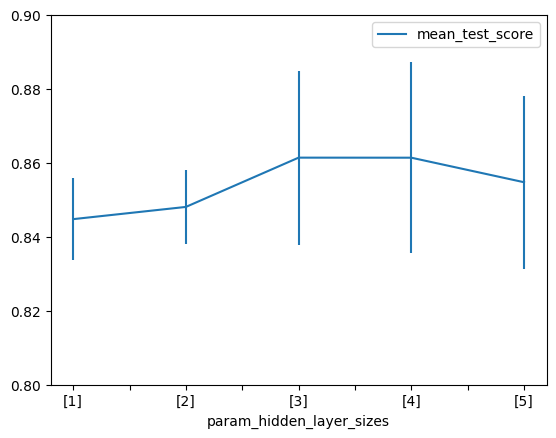

In [15]:
pd.DataFrame(gridSearch.cv_results_)[display].plot(x='param_hidden_layer_sizes',
                                                   y='mean_test_score', yerr='std_test_score', ylim=(0.8, 0.9))
plt.show()

# Step by step Notes



1.   Overview of Neural Networks

a. Neural networks are computational models inspired by the way the human brain works. They are designed to recognize patterns, learn from data, and make predictions or decisions. The basic idea is to mimic the structure and function of biological neural networks to solve complex tasks.

b. Components

  i. Neurons

    In a neural network, a neuron is the basic processing unit. It receives input, performs a computation, and produces an output. The output is then passed to the next layer of neurons. Mathematically, a neuron's output is often determined by an activation function applied to the weighted sum of its inputs.

  ii. Layers

    Neurons are organized into layers. A neural network typically consists of an input layer, one or more hidden layers, and an output layer. Information flows from the input layer through the hidden layers to the output layer. Each layer serves as a level of abstraction, learning more complex representations of the input.

  iii. Weights

    The connections between neurons have associated weights. These weights are learnable parameters that the neural network adjusts during training to optimize its performance. The weights determine the strength of the connections between neurons.


  iv. Activation Functions

    Activation functions introduce non-linearity to the model. They determine the output of a neuron, allowing the network to learn complex patterns. Common activation functions include sigmoid, tanh, and ReLU.




In [16]:
# Example code for a simple neuron

def neuron(inputs, weights, bias, activation_function):
    weighted_sum = np.dot(inputs, weights) + bias
    output = activation_function(weighted_sum)
    return output


In [17]:
# Example code for defining a simple neural network architecture

model = Sequential()
model.add(Dense(units=4, input_dim=2, activation='relu'))  # Input layer
model.add(Dense(units=3, activation='relu'))              # Hidden layer
model.add(Dense(units=1, activation='sigmoid'))            # Output layer


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Example code for initializing weights
#weights = np.random.rand(input_size, output_size)


In [18]:
# Example code for a sigmoid activation function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


In [19]:
#Example of a Neuron

# Example of a neuron in the hidden layer

#Input Layer        Hidden Layer       Output Layer

#   [Fat]               [Neuron 1]             [Output]
#   [Salt]             (Activation)          (Prediction)



# Observation features
fat = 1
salt = 0.2

# Weights and bias for the hidden neuron
weight_fat = 0.4
weight_salt = -0.3
bias_hidden = 0.1

# Neuron computation
weighted_sum_hidden = (fat * weight_fat) + (salt * weight_salt) + bias_hidden

# Activation function (sigmoid in this case)
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

activation_hidden = sigmoid(weighted_sum_hidden)

print(f"Weighted sum in hidden layer: {weighted_sum_hidden}")
print(f"Activation in hidden layer: {activation_hidden}")


Weighted sum in hidden layer: 0.44000000000000006
Activation in hidden layer: 0.6082590307465144


In [20]:
# Example of a neural network with multiple neurons in the hidden layer

# Observation features
fat = 1
salt = 0.2

# Weights and bias for the hidden layer
weights_hidden = np.array([[0.4, -0.3], [0.2, 0.5]])
biases_hidden = np.array([0.1, -0.2])

# Weights and biases for the output layer
weights_output = np.array([0.6, 0.4])
bias_output = 0.3


# Neuron computation for the hidden layer
weighted_sum_hidden = np.dot([fat, salt], weights_hidden) + biases_hidden
activation_hidden = sigmoid(weighted_sum_hidden)



# Neuron computation for the output layer
weighted_sum_output = np.dot(activation_hidden, weights_output) + bias_output
activation_output = sigmoid(weighted_sum_output)


print(f"Weighted sum in hidden layer: {weighted_sum_hidden}")
print(f"Activation in hidden layer: {activation_hidden}")



print(f"Activation in output layer: {activation_output}")


Weighted sum in hidden layer: [ 0.54 -0.4 ]
Activation in hidden layer: [0.63181242 0.40131234]
Activation in output layer: 0.6983835738602231


# Activation Functions

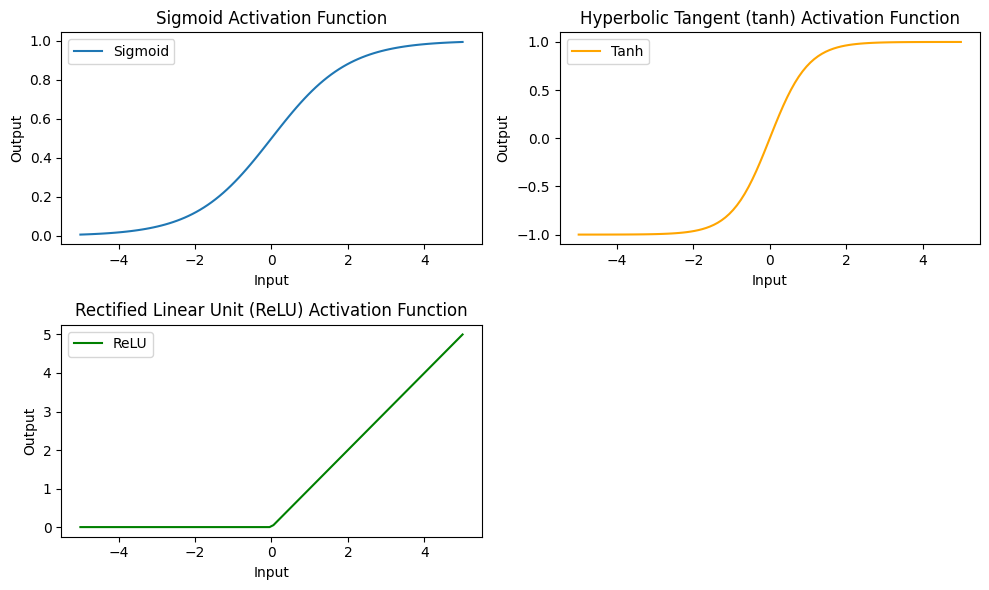

In [21]:


# Activation functions
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def tanh(x):
    return np.tanh(x)

def relu(x):
    return np.maximum(0, x)

# Generate x values
x_values = np.linspace(-5, 5, 100)

# Calculate y values for each activation function
y_sigmoid = sigmoid(x_values)
y_tanh = tanh(x_values)
y_relu = relu(x_values)

# Plot the activation functions
plt.figure(figsize=(10, 6))

plt.subplot(2, 2, 1)
plt.plot(x_values, y_sigmoid, label='Sigmoid')
plt.title('Sigmoid Activation Function')
plt.xlabel('Input')
plt.ylabel('Output')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(x_values, y_tanh, label='Tanh', color='orange')
plt.title('Hyperbolic Tangent (tanh) Activation Function')
plt.xlabel('Input')
plt.ylabel('Output')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(x_values, y_relu, label='ReLU', color='green')
plt.title('Rectified Linear Unit (ReLU) Activation Function')
plt.xlabel('Input')
plt.ylabel('Output')
plt.legend()

plt.tight_layout()
plt.show()

#The sigmoid, tanh, and ReLU functions are commonly used in different types of neural networks.
#The key observation is that they introduce non-linearity to the network, allowing it to learn and represent more complex relationships in the data.


In [22]:
#simple model using tensorflow:


# Define the neural network architecture
model = models.Sequential()

# Input layer with two features
model.add(layers.Dense(units=2, input_dim=2, activation='relu'))

# Hidden layer with two neurons and ReLU activation
model.add(layers.Dense(units=2, activation='relu'))

# Output layer with one neuron and sigmoid activation for binary classification
model.add(layers.Dense(units=1, activation='sigmoid'))

# Print a summary of the model architecture
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 2)                   │               6 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 2)                   │               6 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │               3 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15 (60.00 B)

 Trainable params: 15 (60.00 B)

 Non-trainable params: 0 (0.00 B)

# Training a Neural Network

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8392 - loss: 0.4963 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8373 - loss: 0.4924 
Training Loss: 0.5033223628997803, Training Accuracy: 0.8397997617721558
Validation Loss: 0.4706731140613556, Validation Accuracy: 0.8450000286102295


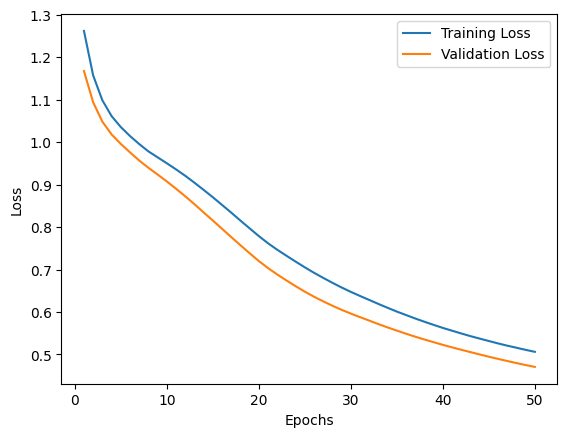

In [23]:
#example of 3-class classification

pred  = ['ALCHL_I', 'PROFIL_I_R', 'SUR_COND', 'VEH_INVL']
out = 'MAX_SEV_IR'
# Create X_train and y_train
X = accidents_df[pred]
y = accidents_df[out]

# Encode the categorical outcome labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y)
y_train_categorical = to_categorical(y_train_encoded)

# Standardize the predictors
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X)

# Define the neural network architecture for multiclass classification
model = models.Sequential()
model.add(layers.Dense(units=10, input_dim=len(pred), activation='relu'))
model.add(layers.Dense(units=5, activation='relu'))
model.add(layers.Dense(units=3, activation='softmax'))  # 3 classes, softmax activation

# Compile the model
model.compile(optimizer='sgd',  # Stochastic Gradient Descent
              loss='categorical_crossentropy',  # Categorical Crossentropy for multiclass classification
              metrics=['accuracy'])

# Train-test split
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train_scaled, y_train_categorical, test_size=0.2, random_state=42)

# Train the model
epochs = 50
batch_size = 32
history = model.fit(X_train_split, y_train_split, epochs=epochs, batch_size=batch_size, validation_data=(X_val_split, y_val_split), verbose=0)

# Evaluate the model on the training and validation data
train_loss, train_accuracy = model.evaluate(X_train_split, y_train_split)
val_loss, val_accuracy = model.evaluate(X_val_split, y_val_split)

print(f"Training Loss: {train_loss}, Training Accuracy: {train_accuracy}")
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

# Plot the training loss and validation loss over epochs

plt.plot(range(1, epochs + 1), history.history['loss'], label='Training Loss')
plt.plot(range(1, epochs + 1), history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [24]:
#binary classification example

bank_df = pd.read_csv(my_drive_path + 'UniversalBank.csv')
bank_df = bank_df.drop(columns=['ID', 'ZIP Code'])

X = bank_df.drop(columns=['Personal Loan'])
y = bank_df['Personal Loan']



Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7299 - loss: 0.6522 - val_accuracy: 0.8825 - val_loss: 0.4735
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9043 - loss: 0.4373 - val_accuracy: 0.9050 - val_loss: 0.3605
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9111 - loss: 0.3398 - val_accuracy: 0.9075 - val_loss: 0.2919
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8985 - loss: 0.2963 - val_accuracy: 0.9137 - val_loss: 0.2413
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9105 - loss: 0.2487 - val_accuracy: 0.9250 - val_loss: 0.2046
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9248 - loss: 0.2071 - val_accuracy: 0.9413 - val_loss: 0.1750
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9323 - loss: 0.1834 - val_accuracy: 0.9475 - val_loss: 0.1535
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9416 - loss: 0.1683 - val_accuracy: 0.9563 - val_

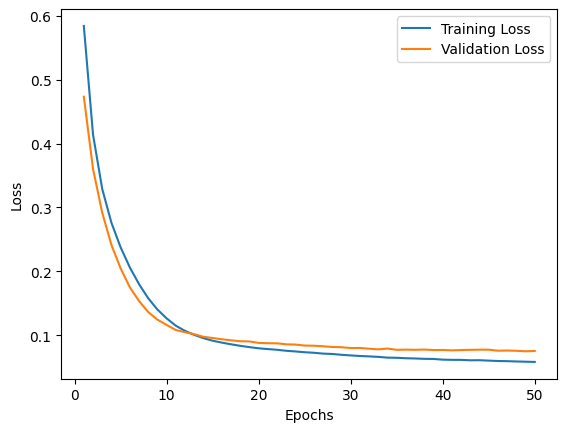

In [25]:

# Select features and outcome
features = ['Age', 'Experience', 'Income', 'Family', 'CCAvg', 'Education', 'Mortgage', 'Securities Account',
            'CD Account', 'Online', 'CreditCard']
outcome = 'Personal Loan'

# Create X and y
X = bank_df[features]
y = bank_df[outcome]

# Standardize the predictors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define the neural network architecture for binary classification
model = models.Sequential()
model.add(layers.Dense(units=8, input_dim=len(features), activation='relu'))
model.add(layers.Dense(units=4, activation='relu'))
model.add(layers.Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam',  # Adam optimizer
              loss='binary_crossentropy',  # Binary Crossentropy for binary classification
              metrics=['accuracy'])

# Train the model
epochs = 50
batch_size = 32
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1)

# Evaluate the model on the testing data
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Plot the training loss and validation loss over epochs

plt.plot(range(1, epochs + 1), history.history['loss'], label='Training Loss')
plt.plot(range(1, epochs + 1), history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [26]:
#how would we use it in a new record:

# Create an example of a new record
new_record = pd.DataFrame({
    'Age': [35],
    'Experience': [10],
    'Income': [80000],
    'Family': [3],
    'CCAvg': [5],
    'Education': [2],
    'Mortgage': [200],
    'Securities Account': [0],
    'CD Account': [1],
    'Online': [1],
    'CreditCard': [0]
})

# Standardize the new record using the same scaler used for training data
new_record_scaled = scaler.transform(new_record)

# Make a prediction
prediction = model.predict(new_record_scaled)
print("Prediction: ", prediction )
# Convert the prediction to a binary outcome (0 or 1)
binary_prediction = (prediction > 0.5).astype(int)

print(f"Probability of getting a Personal Loan: {prediction[0, 0]}")
print(f"Binary Prediction: {binary_prediction[0, 0]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Prediction:  [[1.]]
Probability of getting a Personal Loan: 1.0
Binary Prediction: 1


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 134516848.0000 - mae: 10949.3301 - val_loss: 114482272.0000 - val_mae: 10163.3369
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 126379464.0000 - mae: 10709.8936 - val_loss: 114474872.0000 - val_mae: 10162.9902
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 131211296.0000 - mae: 10847.3193 - val_loss: 114467104.0000 - val_mae: 10162.6279
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 133293968.0000 - mae: 10955.0576 - val_loss: 114456864.0000 - val_mae: 10162.1641
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 131835384.0000 - mae: 10870.0674 - val_loss: 114443032.0000 - val_mae: 10161.5479
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 135647456.0000 - mae: 11055.1348 - val_loss: 114423704.0000 - val_mae: 10160.7041
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 134080928.0000 - mae: 10915.4346 - val_loss: 114397472.0000 - val_mae: 10159.5654
Epoch 8/50
29/29 ━━━━━━━━━━━━━━

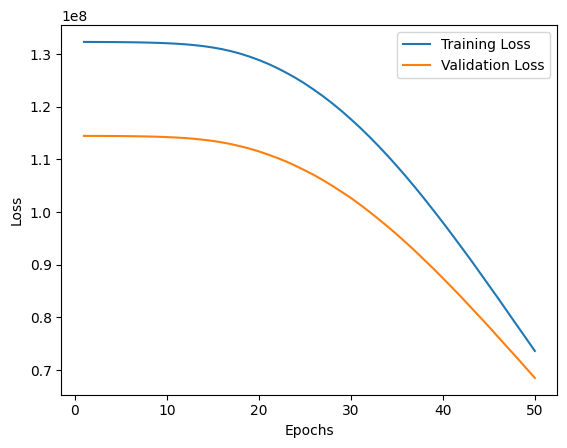

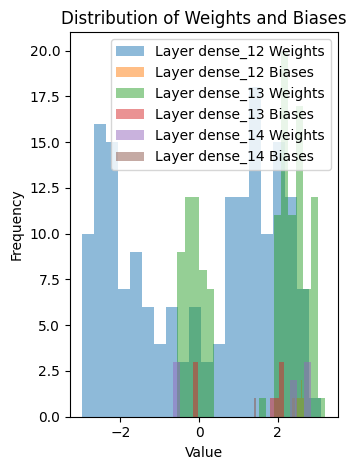

In [27]:
#regression example:

#notice how the model architecture changes

toyotaCorolla_df = pd.read_csv(my_drive_path+'ToyotaCorolla.csv')#.iloc[:1000,:]
toyotaCorolla_df = toyotaCorolla_df.rename(columns={'Age_08_04': 'Age', 'Quarterly_Tax': 'Tax'})

predictors = ['Age', 'KM', 'Fuel_Type', 'HP', 'Met_Color', 'Automatic', 'CC',
              'Doors', 'Tax', 'Weight']
outcome = 'Price'


# Create X and y
X = toyotaCorolla_df[predictors]
y = toyotaCorolla_df[outcome]

# Convert categorical variables to one-hot encoding
X_encoded = pd.get_dummies(X, columns=['Fuel_Type'], drop_first=True)

# Standardize the predictors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define the neural network architecture for regression
model = models.Sequential()
model.add(layers.Dense(units=16, input_dim=X_scaled.shape[1], activation='relu'))
model.add(layers.Dense(units=8, activation='relu'))
model.add(layers.Dense(units=1, activation='linear'))  # Linear activation for regression

# Compile the model
model.compile(optimizer='adam',  # Adam optimizer
              loss='mean_squared_error',  # Mean Squared Error for regression
              metrics=['mae'])  # Mean Absolute Error as an additional metric

# Train the model
epochs = 50
batch_size = 32
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1)

# Evaluate the model on the testing data
test_loss, test_mae = model.evaluate(X_test, y_test)

print(f"Test Mean Squared Error: {test_loss}")
print(f"Test Mean Absolute Error: {test_mae}")

# Plot the training loss and validation loss over epochs


plt.plot(range(1, epochs + 1), history.history['loss'], label='Training Loss')
plt.plot(range(1, epochs + 1), history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Visualize changes in weights and biases
plt.subplot(1, 2, 2)
for layer in model.layers:
    if isinstance(layer, tf.keras.layers.Dense):
        weights, biases = layer.get_weights()
        plt.hist(weights.flatten(), alpha=0.5, label=f'Layer {layer.name} Weights', bins=20)
        plt.hist(biases.flatten(), alpha=0.5, label=f'Layer {layer.name} Biases', bins=20)

plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distribution of Weights and Biases')

plt.tight_layout()
plt.show()


Iteration 1, loss = 64389758.96224752
Iteration 1, loss = 64387674.03752940
Iteration 1, loss = 64385676.95898370
Iteration 1, loss = 64383816.10106149
Iteration 1, loss = 64382068.41497518
Iteration 1, loss = 64380401.56963737
Iteration 1, loss = 64378822.89132918
Iteration 1, loss = 64377351.79826004
Iteration 1, loss = 64375987.32454346
Iteration 1, loss = 64374702.15832982
Iteration 1, loss = 64373504.27209881
Iteration 1, loss = 64372347.52730674
Iteration 1, loss = 64371231.84814928
Iteration 1, loss = 64370136.14972454
Iteration 1, loss = 64369060.65533119
Iteration 1, loss = 64367999.38816404
Iteration 1, loss = 64366938.14433958
Iteration 1, loss = 64365875.19359977
Iteration 1, loss = 64364808.21295337
Iteration 1, loss = 64363726.03699937
Iteration 1, loss = 64362625.23980790
Iteration 1, loss = 64361505.30602678
Iteration 1, loss = 64360357.43708228
Iteration 1, loss = 64359184.76914720
Iteration 1, loss = 64357982.16018178
Iteration 1, loss = 64356746.14045564
Iteration 1,

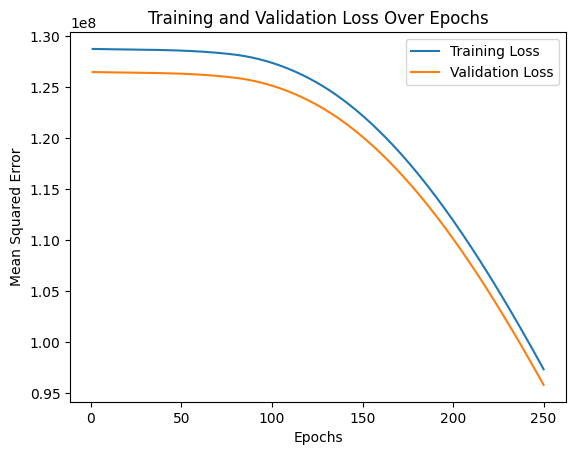

In [28]:
#There are many different libraries that can help you create/train a nn for your data.
#Among the simplest is the sklearn.neural_network import MLPRegressor
# Create X and y
X = toyotaCorolla_df[predictors]
y = toyotaCorolla_df[outcome]

# Convert categorical variables to one-hot encoding
X_encoded = pd.get_dummies(X, columns=['Fuel_Type'], drop_first=True)

# Standardize the predictors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define the MLPRegressor model
model = MLPRegressor(hidden_layer_sizes=(16, 8),
                     activation='relu',
                     solver='adam',
                     max_iter=1,  # Set max_iter to 1 for partial_fit
                     random_state=42,
                     verbose=True)

# Training parameters
epochs = 250
batch_size = 32

# Lists to store training and validation loss
train_loss_list = []
val_loss_list = []

# Training loop
for epoch in range(epochs):
    # Perform partial_fit for each epoch
    model.partial_fit(X_train, y_train)

    # Calculate training loss
    y_train_pred = model.predict(X_train)
    train_loss = mean_squared_error(y_train, y_train_pred)
    train_loss_list.append(train_loss)

    # Calculate validation loss
    y_val_pred = model.predict(X_test)
    val_loss = mean_squared_error(y_test, y_val_pred)
    val_loss_list.append(val_loss)

# Plot the training and validation loss
plt.plot(range(1, epochs + 1), train_loss_list, label='Training Loss')
plt.plot(range(1, epochs + 1), val_loss_list, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.show()

#could we do better here??